# Milestone 1

### TODO:
* extract 1-3 outcome variables
    * Feature engineering: often you may need to transform or generate your own outcome variable
    * If you have continuous income, often useful to generate binary outcome of high vs low income
* 5-10 predictor variables from the data
* identify important sub-groups (for example, by gender or by year) AND use them in sub-group analysis
* at least two descriptive statistics tables
    * one for all sample
    * one by group (e.g. 2017 vs. 2022; male vs. female; old vs. young; Allston-Brighton vs. Roxbury) 
* analytical plans and methods (a minimum of 2 methods presented in this course)

In [28]:
# Loading required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from plotly import express as px

In [3]:
# Load your data
df = pd.read_csv('Crime Data 18+20+22.csv')

/var/folders/5y/pjrsw60n65124xb_fjnr_68m0000gn/T/ipykernel_92490/266777501.py:2: DtypeWarning: Columns (1,3,7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Crime Data 18+20+22.csv')


In [4]:
df["DISTRICT"].replace('A1', 'Downtown & Charlestown', inplace=True)
df["DISTRICT"].replace('A15', 'Downtown & Charlestown', inplace=True)
df["DISTRICT"].replace('A7', 'East Boston', inplace=True)
df["DISTRICT"].replace('B2', 'Roxbury', inplace=True)
df["DISTRICT"].replace('B3', 'Mattapan', inplace=True)
df["DISTRICT"].replace('C6', 'South Boston', inplace=True)
df["DISTRICT"].replace('C11', 'Dorchester', inplace=True)
df["DISTRICT"].replace('D4', 'South End', inplace=True)
df["DISTRICT"].replace('D14', 'Brighton', inplace=True)
df["DISTRICT"].replace('E5', 'West Roxbury', inplace=True)
df["DISTRICT"].replace('E13', 'Jamaica Plain', inplace=True)
df["DISTRICT"].replace('E18', 'Hyde Park', inplace=True)
df["DISTRICT"].dropna(inplace=True)

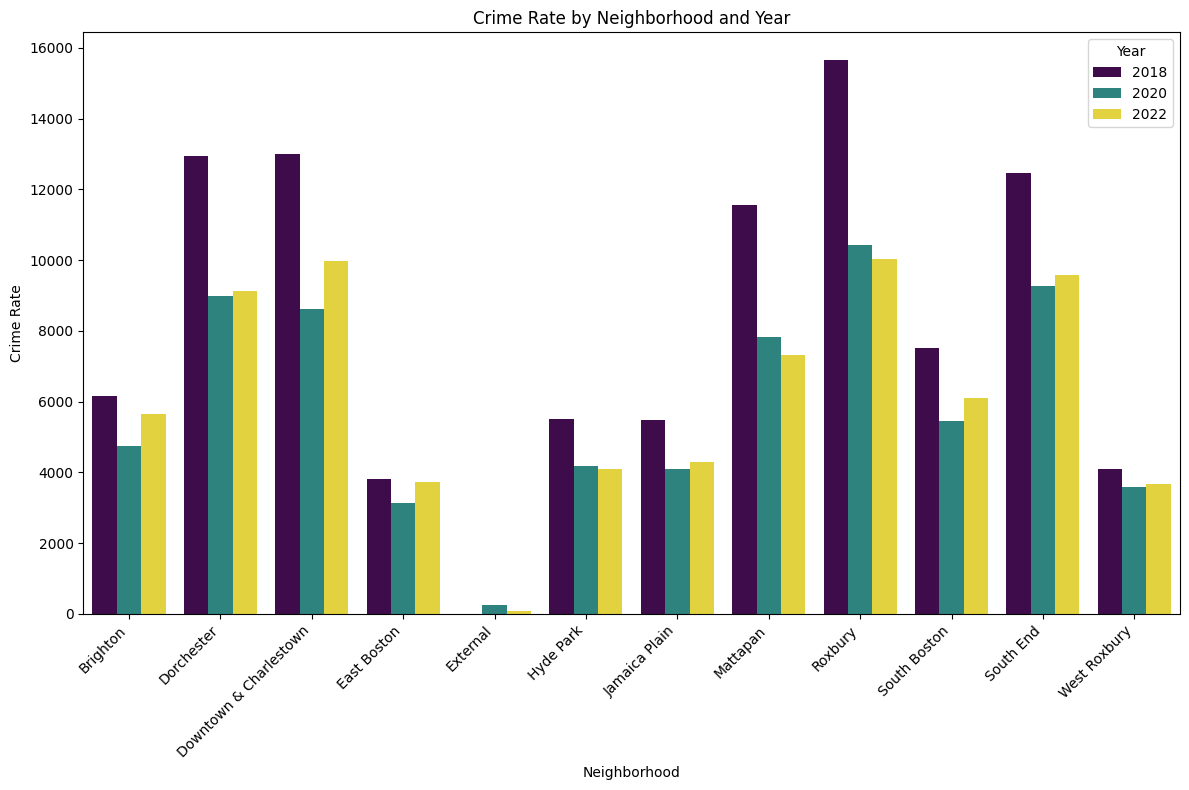

In [ ]:
# aggregation by DISTRICT and YEAR to count incidents
district_yearly_counts = df.groupby(['DISTRICT', 'YEAR']).size().unstack(fill_value=0)


district_yearly_counts.drop(columns=["Trend"], inplace=True)
plot_data = district_yearly_counts.reset_index().melt(id_vars=['DISTRICT'], 
                                                      var_name='Year', 
                                                      value_name='Crime_Rate')

plt.figure(figsize=(12, 8))
sns.barplot(x='DISTRICT', y='Crime_Rate', hue='Year', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Neighborhood and Year')
plt.legend(title='Year')
plt.tight_layout()

# Show the plot
plt.show()

Index(['PROPERTY_CRIME', 'SHOOTING', 'VIOLENT_CRIME'], dtype='object', name='CRIME_TYPE')


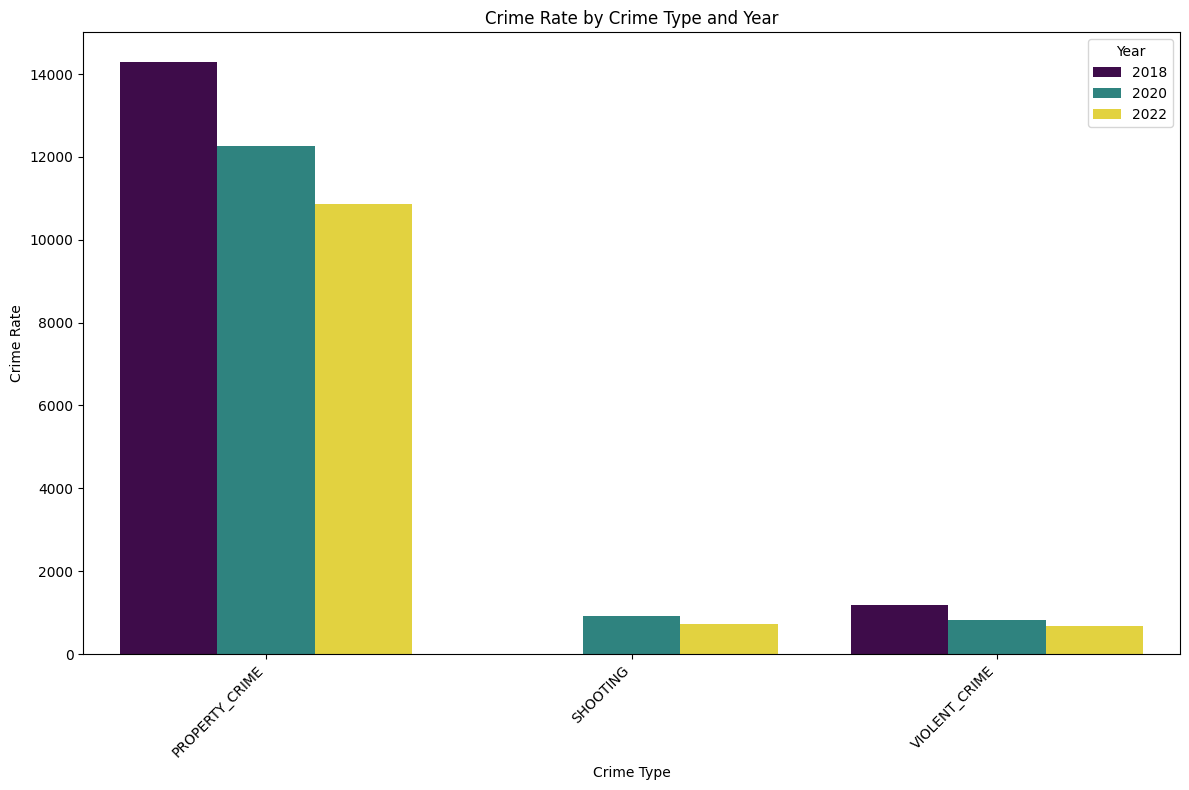

In [7]:
property_crimes = ['BURGLARY', 'LARCENY', 'AUTO THEFT', 'ARSON']
violent_crimes = ['HOMICIDE', 'ROBBERY', 'AGGRAVATED ASSAULT', 'RAPE']
df['CRIME_TYPE'] = df.apply(lambda x: 'VIOLENT_CRIME' if any(x['OFFENSE_DESCRIPTION'].upper().startswith(crime) for crime in violent_crimes) else "PROPERTY_CRIME" if any(x['OFFENSE_DESCRIPTION'].upper().startswith(crime) for crime in property_crimes) else 'SHOOTING' if x['SHOOTING'] == 1 else 'OTHER', axis=1)


crime_type_yearly_counts = df.groupby(['CRIME_TYPE', 'YEAR']).size().unstack(fill_value=0)
crime_type_yearly_counts.drop(index='OTHER', inplace=True)
print(crime_type_yearly_counts.index)
plot_data = crime_type_yearly_counts.reset_index().melt(id_vars=['CRIME_TYPE'], 
                                                      var_name='Year', 
                                                      value_name='Crime_Rate')

plt.figure(figsize=(12, 8))
sns.barplot(x='CRIME_TYPE', y='Crime_Rate', hue='Year', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Crime Type')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Crime Type and Year')
plt.legend(title='Year')
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
crime_type_district_yearly_counts = df[df['CRIME_TYPE'] != 'OTHER'].groupby(['DISTRICT', 'CRIME_TYPE']).size().unstack(fill_value=0)
crime_type_district_yearly_counts_percentage = crime_type_district_yearly_counts.div(crime_type_district_yearly_counts.sum(axis=1), axis=0) * 100
plot_data = crime_type_district_yearly_counts_percentage.reset_index().melt(id_vars=['DISTRICT'], 
                                                      var_name='CRIME_TYPE', 
                                                      value_name='Crime_Type_Percent')
fig = px.line(
    plot_data,
    x = 'DISTRICT',
    y = 'Crime_Type_Percent',
    color = 'CRIME_TYPE',
    )
fig.show()

In [9]:
crime_daily_counts = df.groupby(['DAY_OF_WEEK']).size()

total_counts = crime_daily_counts.sum()

crime_daily_percentage = (crime_daily_counts / total_counts) * 100

plot_data = crime_daily_percentage.reset_index(name='Percentage')
plot_data['DAY_OF_WEEK'] = pd.Categorical(plot_data['DAY_OF_WEEK'],
                                        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                        ordered=True)
plot_data.sort_values('DAY_OF_WEEK', inplace=True)

fig = px.line(
    plot_data,
    x = 'DAY_OF_WEEK',
    y = 'Percentage'
    # color = 'CRIME_TYPE',
    )
fig.show()

fig = px.bar(
    plot_data,
    x = 'DAY_OF_WEEK',
    y = 'Percentage'
    # color = 'CRIME_TYPE',
    )
fig.show()

fig = px.pie(
    plot_data, 
    names='DAY_OF_WEEK', 
    values='Percentage', 
    title='Percentage of Crimes by Day of the Week',
    color='DAY_OF_WEEK', 
    color_discrete_sequence=px.colors.sequential.Plasma
    ) 
fig.show()

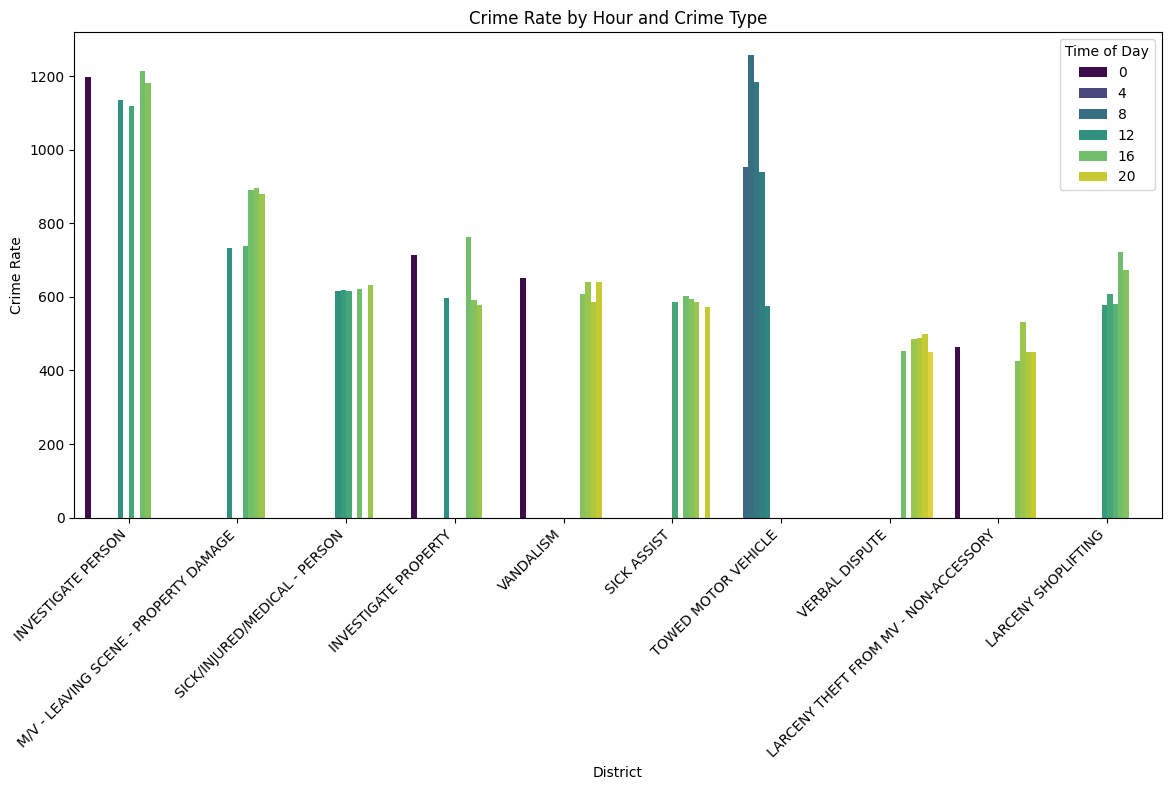

In [46]:
crime_type_hour_counts = df.groupby(['OFFENSE_DESCRIPTION', 'HOUR']).size().unstack(fill_value=0)
crime_type_total_counts = df.groupby(['OFFENSE_DESCRIPTION']).size().reset_index(name='Total')
top_crime_type = crime_type_total_counts.set_index('OFFENSE_DESCRIPTION')
top_crime_type = top_crime_type.sort_values(by='Total', ascending=False).head(10)

crime_type_hour_counts = crime_type_hour_counts.reset_index().melt(id_vars=['OFFENSE_DESCRIPTION'], 
                                            var_name='HOUR', 
                                            value_name='Hour_Wise_Crime_Rate')
top_hour_per_crime = []
for crime in top_crime_type.index:
    top_hours = crime_type_hour_counts[crime_type_hour_counts['OFFENSE_DESCRIPTION'] == crime].nlargest(5, 'Hour_Wise_Crime_Rate')
    top_hour_per_crime.append(top_hours)

plot_data = pd.concat(top_hour_per_crime, ignore_index=True)
plot_data.set_index('OFFENSE_DESCRIPTION', inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='OFFENSE_DESCRIPTION', y='Hour_Wise_Crime_Rate', hue='HOUR', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('District')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Hour and Crime Type')
plt.legend(title='Time of Day')
plt.tight_layout()

# Show the plot
plt.show()

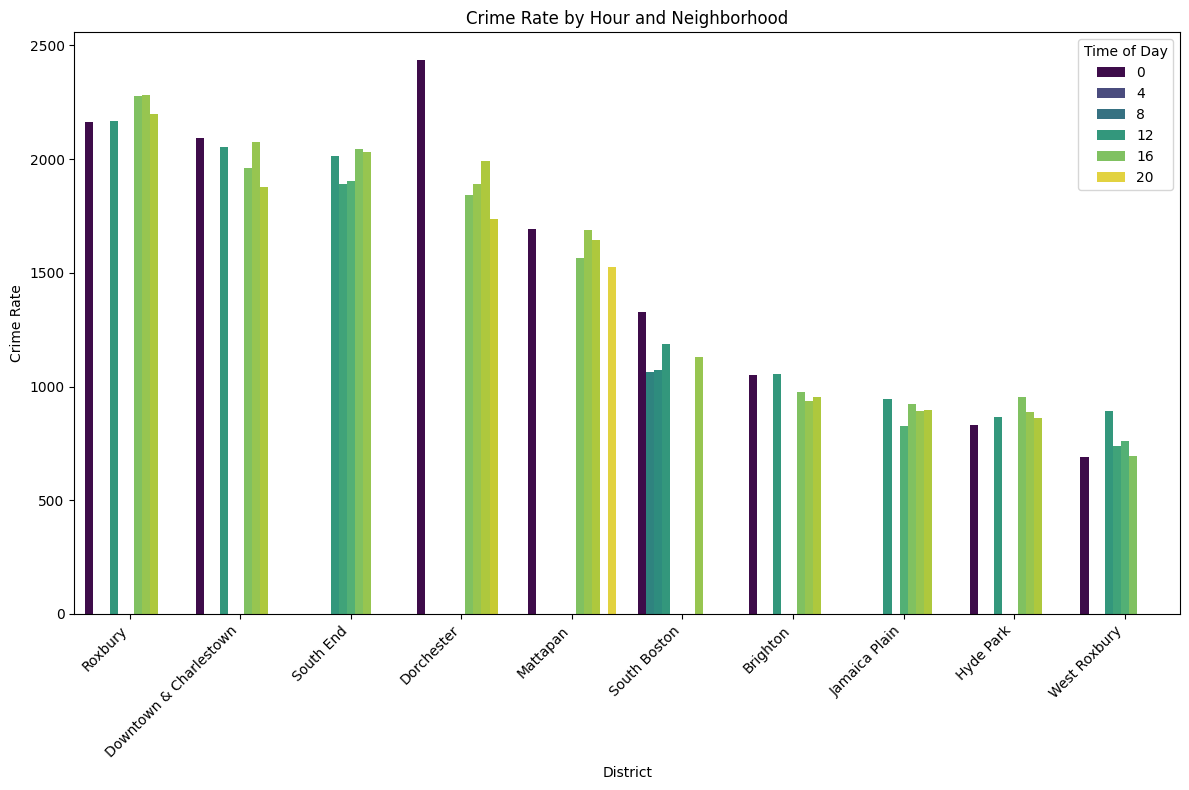

In [11]:
crime_type_hour_counts = df.groupby(['DISTRICT', 'HOUR']).size().unstack(fill_value=0)
crime_type_total_counts = df.groupby(['DISTRICT']).size().reset_index(name='Total')
top_crime_type = crime_type_total_counts.set_index('DISTRICT')
top_crime_type = top_crime_type.sort_values(by='Total', ascending=False).head(10)
top_crime_type.index

crime_type_hour_counts = crime_type_hour_counts.reset_index().melt(id_vars=['DISTRICT'], 
                                            var_name='HOUR', 
                                            value_name='Hour_Wise_Crime_Rate')
top_hour_per_crime = []
for crime in top_crime_type.index:
    top_hours = crime_type_hour_counts[crime_type_hour_counts['DISTRICT'] == crime].nlargest(5, 'Hour_Wise_Crime_Rate')
    top_hour_per_crime.append(top_hours)

plot_data = pd.concat(top_hour_per_crime, ignore_index=True)
plot_data.set_index('DISTRICT', inplace=True)

# print(plot_data)
# print(plot_data)
plt.figure(figsize=(12, 8))
sns.barplot(x='DISTRICT', y='Hour_Wise_Crime_Rate', hue='HOUR', data=plot_data, palette="viridis")

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('District')
plt.ylabel('Crime Rate')
plt.title('Crime Rate by Hour and Neighborhood')
plt.legend(title='Time of Day')
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
placewise_crime_count = df.groupby(['Lat', 'Long']).size()

plot_data = placewise_crime_count.reset_index(name='Count')

plot_data.head()

Lat          Long  Count
0  1.327276e-07  5.249691e-08      1
1  4.221441e+01 -7.100939e+01      1
2  4.223241e+01 -7.112972e+01      1
3  4.223266e+01 -7.113070e+01      1
4  4.223266e+01 -7.113070e+01      1

In [43]:
with open('geo_json_data.json') as f:
    geojson_data = json.load(f)

raw_df = pd.read_csv('Crime Data 18+20+22.csv')
crime_counts = raw_df.groupby('DISTRICT').size().reset_index(name='crime_count')

for feature in geojson_data['features']:
    feature_id = feature['properties']['DISTRICT']
    feature['properties']['crime_count'] = crime_counts.loc[
        crime_counts['DISTRICT'] == feature_id, 'crime_count'
    ].sum() 

district_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": feature['properties'],
            "geometry": feature['geometry']
        }
        for feature in geojson_data['features']
    ]
}

fig = px.choropleth_mapbox(
    crime_counts,
    geojson=geojson_data,
    color="crime_count",
    locations='DISTRICT',
    featureidkey="properties.DISTRICT",
    title="District-wise Crime Count",
    mapbox_style="carto-positron",
    center={"lat": 42.3601, "lon": -71.0589}, 
    zoom=9.5,
    opacity=0.7,
    color_continuous_scale="Reds"
)


fig.show()

/var/folders/5y/pjrsw60n65124xb_fjnr_68m0000gn/T/ipykernel_92490/1190523597.py:4: DtypeWarning:

Columns (1,3,7,13) have mixed types. Specify dtype option on import or set low_memory=False.

